# Data pre-processing and preparation

### Obtaining the data

We used the following python script:

In [ ]:
# python features.py

### Unifying the class labels with the data

In [46]:
import pandas as pd
df = pd.read_csv('urbansounds_features.csv')

In [47]:
# Replace the 'Label' column with the extracted value
df['Label'] = df['Label'].str.split('-').str[1]

# Display the first few rows of the updated DataFrame
print(df.head())

   chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms     centroid  \
0     0.494262    0.568759     0.267266       3.465249  0.068657  2177.483658   
1     0.422076    0.556903     0.270826       3.132792  0.076706  1623.980658   
2     0.575613    0.606710     0.275953       2.257988  0.044251  2615.200756   
3     0.175040    0.526637     0.258603       1.481219  0.043195  1223.789196   
4     0.412279    0.608818     0.264944       0.806509  0.035636  1470.863386   

     bandwidth   contrast  flatness      rolloff  ...  mcffs_32  mcffs_33  \
0  3649.518344  19.685466  0.002088  4745.917969  ... -2.700133 -0.350788   
1  2897.277104  21.508354  0.001123  2743.891814  ... -5.048006 -1.626652   
2  4200.855657  18.001559  0.003370  6143.329229  ... -1.015445  0.989107   
3  1367.391253  16.179755  0.583564  2473.821756  ...  2.447487 -1.956081   
4  2296.662162  12.349992  0.353831  3264.932914  ...  0.232175  0.326373   

   mcffs_34  mcffs_35  mcffs_36  mcffs_37  mcffs_3

In [49]:
object_columns = df.select_dtypes(include=['object']).columns
object_columns

Index(['fourier_tempogram', 'Label'], dtype='object')

In [50]:
df['Label'] = df['Label'].astype('int64')

In [51]:
df['fourier_tempogram']

0         (0.3276304304599762+0.02266499027609825j)
1       (0.4535762667655945-0.0053963325917720795j)
2        (0.2704409956932068-0.004409016575664282j)
3        (0.24510568380355835-0.06169594079256058j)
4         (0.2566556930541992-0.04115929454565048j)
                           ...                     
8727    (0.4560413062572479+0.0012621254427358508j)
8728    (0.44239211082458496-0.000281495857052505j)
8729     (0.4610893130302429+0.006387857720255852j)
8730     (0.4551824927330017-0.006821506191045046j)
8731     (0.450885146856308+0.0021665075328201056j)
Name: fourier_tempogram, Length: 8732, dtype: object

### Check interval of the values per column

In [7]:
column_intervals = df.describe().loc[['min', 'max']]
column_intervals

,chroma_stft,chroma_cqt,chroma_cens,melspectogram,rms,centroid,bandwidth,contrast,flatness,rolloff,...,mcffs_31,mcffs_32,mcffs_33,mcffs_34,mcffs_35,mcffs_36,mcffs_37,mcffs_38,mcffs_39,mcffs_40
min,0.008760,0.118011,0.126660,0.017318,0.001788,49.252793,66.012024,3.938343,1.648695e-07,81.951002,...,-20.268456,-12.144473,-19.343061,-28.116508,-16.987791,-14.576315,-36.001620,-23.080887,-25.212177,-13.395362
max,0.845297,0.796146,0.286841,65.208150,0.579545,10907.707763,7532.173550,29.609336,9.798845e-01,18628.717306,...,19.353420,19.055628,15.425904,22.999128,20.503590,26.710932,23.912758,17.683758,17.977505,30.761436


In [9]:
df[df.columns.difference(['Label'])] = (df[df.columns.difference(['Label'])] - df[df.columns.difference(['Lable'])].min()) / (df[df.columns.difference(['Label'])].max() - df[df.columns.difference(['Label'])].min())
df[df.columns.difference(['Label'])]


TypeError: unsupported operand type(s) for -: 'str' and 'str'

### Check the distribution of the classes

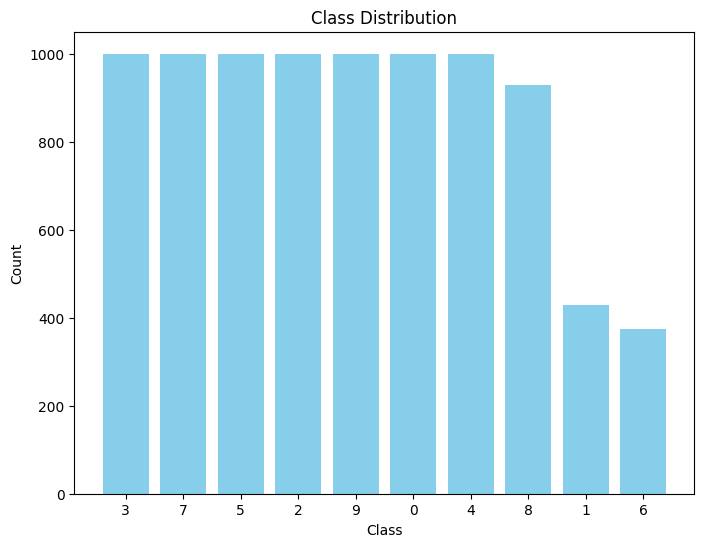

In [5]:
import matplotlib.pyplot as plt

class_counts = df['Label'].value_counts()
class_labels = class_counts.index
class_values = class_counts.values

plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_values, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()